In [1]:
import matplotlib.pyplot as plt
from collections import OrderedDict

from copy import deepcopy
import torch
from torchvision import models  
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models

# download the data
data_dir = 'dataset'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'


In [ ]:
# Process with some data transformation, including normalization, resizing, cropping, flipping, and rotation
data_transforms = {
    'training': transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(30),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224,
                                                          0.225])]),

    'validation': transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          [0.485, 0.456, 0.406],
                                          [0.229, 0.224, 0.225])]),

    'testing': transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406],
                                                        [0.229, 0.224,
                                                         0.225])])
}
# This specifies how many images to process per training/validation
batch_size = 32

image_datasets = {
    'training': datasets.ImageFolder(train_dir,
                                     transform=data_transforms['training']),
    'testing': datasets.ImageFolder(test_dir,
                                    transform=data_transforms['testing']),
    'validation': datasets.ImageFolder(valid_dir,
                                       transform=data_transforms['validation'])
}

dataloaders = {
    'training': torch.utils.data.DataLoader(image_datasets['training'],
                                            batch_size=batch_size,
                                            shuffle=True),
    'testing': torch.utils.data.DataLoader(image_datasets['testing'],
                                           batch_size=batch_size,
                                           shuffle=False),
    'validation': torch.utils.data.DataLoader(image_datasets['validation'],
                                              batch_size=batch_size,
                                              shuffle=True)
}

# get the length of each dataloaders with batch size 32
training_len = len(dataloaders['training'])
test_len = len(dataloaders['testing'])
validation_len = len(dataloaders['validation'])
class_to_idx = image_datasets['training'].class_to_idx

print('We have ', training_len, 'batches of training images;', 'each with',
      batch_size, 'images')
print('We have ', validation_len, 'batches of validation images;', 'each with',
      batch_size, 'images')
print('We have ', test_len, 'batches of testing images;', 'each with',
      batch_size, 'images')

# Let us preview size of each batch
print('Single batch', next(iter(dataloaders['training']))[0].shape)

We have  100 batches of training images; each with 32 images
We have  18 batches of validation images; each with 32 images
We have  3 batches of testing images; each with 32 images
Single batch torch.Size([32, 3, 224, 224])


In [3]:
# Transfer learning with GoogLeNet
model = models.googlenet(weights='DEFAULT')

In [ ]:
for param in model.parameters():
    param.requires_grad = False

print(model)

# This is the original classifier with GoogleNet
print()
print('Original classifier of GoogLeNet')
print(model.fc)

# Defining number of hidden units in our fully connected layer
number_of_classes = len(class_to_idx) 
model.fc = nn.Linear(1024, number_of_classes)
print(model)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 10
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()  # Changed from NLLLoss to work with raw logits
print_every = 5

validation_accuracies, training_accuracies = [], []
validation_losses, training_losses = [], []

best_validation_accuracy = 0
best_model_weights = None

for e in range(epochs):

    training_loss = training_accuracy = 0
    validation_loss = validation_accuracy = 0

    model.train()
    for batch_idx, (images, labels) in enumerate(dataloaders['training']):

        # Moving images & labels to the GPU if there is one
        images, labels = images.to(device), labels.to(device)

        # Zero gradients first
        optimizer.zero_grad()

        # Forward pass
        logits = model.forward(images)
        loss = criterion(logits, labels)
        
        # Backward pass to compute gradients
        loss.backward()
        
        # Update weights after backward
        optimizer.step()

        # Calculating metrics
        ps = torch.softmax(logits, dim=1)
        top_ps, top_class = ps.topk(1, dim=1)
        matches = (top_class == labels.view(*top_class.shape)).type(
            torch.FloatTensor)
        train_batch_accuracy = matches.mean()

        # Tracking metrics
        training_loss += loss.item()
        train_batch_loss = loss.item()
        training_accuracy += train_batch_accuracy.item()

        if batch_idx % print_every == 0:
            print('epoch', e, 'batch', batch_idx)
            print('training loss per batch', train_batch_loss)
            print('training accuracy per batch', train_batch_accuracy.item())

    # Validation
    model.eval()
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(
                dataloaders['validation']):
            images, labels = images.to(device), labels.to(device)
            logits = model(images)  # Changed variable name
            loss = criterion(logits, labels)
            ps = torch.softmax(logits, dim=1)  # Changed from exp
            top_ps, top_class = ps.topk(1, dim=1)
            matches = (top_class == labels.view(*top_class.shape)).type(
                torch.FloatTensor)
            validation_batch_accuracy = matches.mean()

            validation_loss += loss.item()
            validation_batch_loss = loss.item()
            validation_accuracy += validation_batch_accuracy

    # Save best model
    if validation_accuracy >= best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        best_model_weights = model.state_dict()

    # Summary per epoch
    print('epoch', e, 'summary')
    print('avg training loss per epoch', training_loss / training_len)
    print('avg training accuracy per epoch', training_accuracy / training_len)
    training_losses.append(training_loss / training_len)
    training_accuracies.append(training_accuracy / training_len)

    print('avg validation loss per epoch', validation_loss / validation_len)
    print('avg validation accuracy per epoch',
          validation_accuracy / validation_len)
    validation_losses.append(validation_loss / validation_len)
    validation_accuracies.append(validation_accuracy / validation_len)

    print()

epoch 0 batch 0
training loss per batch 1.876617431640625
training accuracy per batch 0.0625
epoch 0 batch 5
training loss per batch 1.7793283462524414
training accuracy per batch 0.1875
epoch 0 batch 10
training loss per batch 1.654608130455017
training accuracy per batch 0.3125
epoch 0 batch 15
training loss per batch 1.6375173330307007
training accuracy per batch 0.34375
epoch 0 batch 20
training loss per batch 1.598780632019043
training accuracy per batch 0.28125
epoch 0 batch 25
training loss per batch 1.4488565921783447
training accuracy per batch 0.5625
epoch 0 batch 30
training loss per batch 1.5091675519943237
training accuracy per batch 0.4375
epoch 0 batch 35
training loss per batch 1.3764734268188477
training accuracy per batch 0.46875
epoch 0 batch 40
training loss per batch 1.561377763748169
training accuracy per batch 0.375
epoch 0 batch 45
training loss per batch 1.3257347345352173
training accuracy per batch 0.5
epoch 0 batch 50
training loss per batch 1.47004175186157

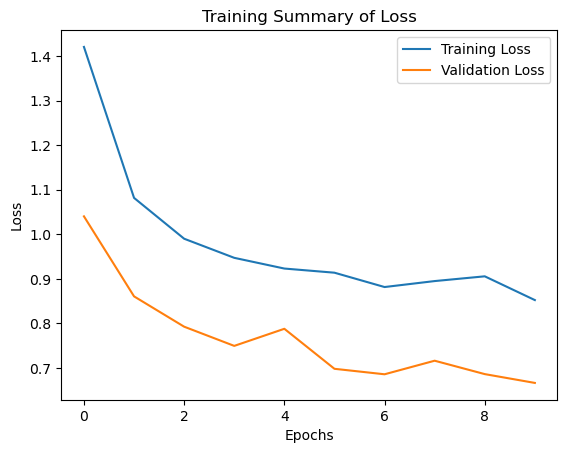

In [ ]:
# Plotting the summary of training and validation losses
plt.figure()
plt.title("Training Summary of Loss")
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

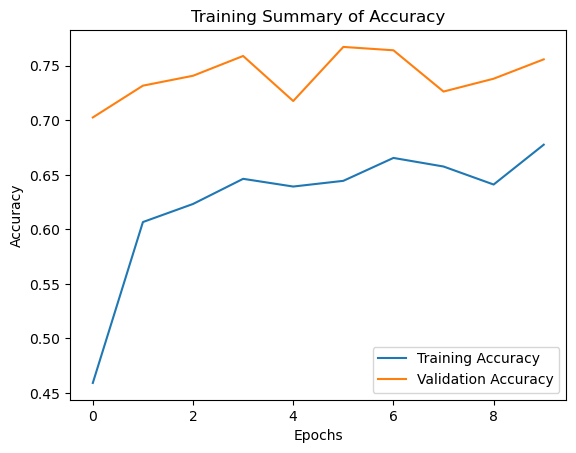

In [ ]:
# Plotting the summary of training and validation accuracies
plt.figure()
plt.title("Training Summary of Accuracy")
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
# Load the best model so far
model.load_state_dict(best_model_weights)
model.eval()  # Set to evaluation mode

total_correct = 0
total_samples = 0
predictions = []
label_data = []

with torch.no_grad():  # Disable gradient computation for testing
    for images, labels in dataloaders['testing']:
        images, labels = images.to(device), labels.to(device)
        
        logits = model(images)
        ps = torch.softmax(logits, dim=1)
        
        top_ps, top_class = ps.topk(1, dim=1)
        
        total_correct += (top_class == labels.view(*top_class.shape)).sum().item()
        total_samples += labels.size(0)
        
        predictions.append(top_class)
        label_data.append(labels)

test_accuracy = total_correct / total_samples
print(f'Test Accuracy: {test_accuracy:.4f}')

predictions = torch.cat(predictions)
label_data = torch.cat(label_data)


Test Accuracy: 0.7955


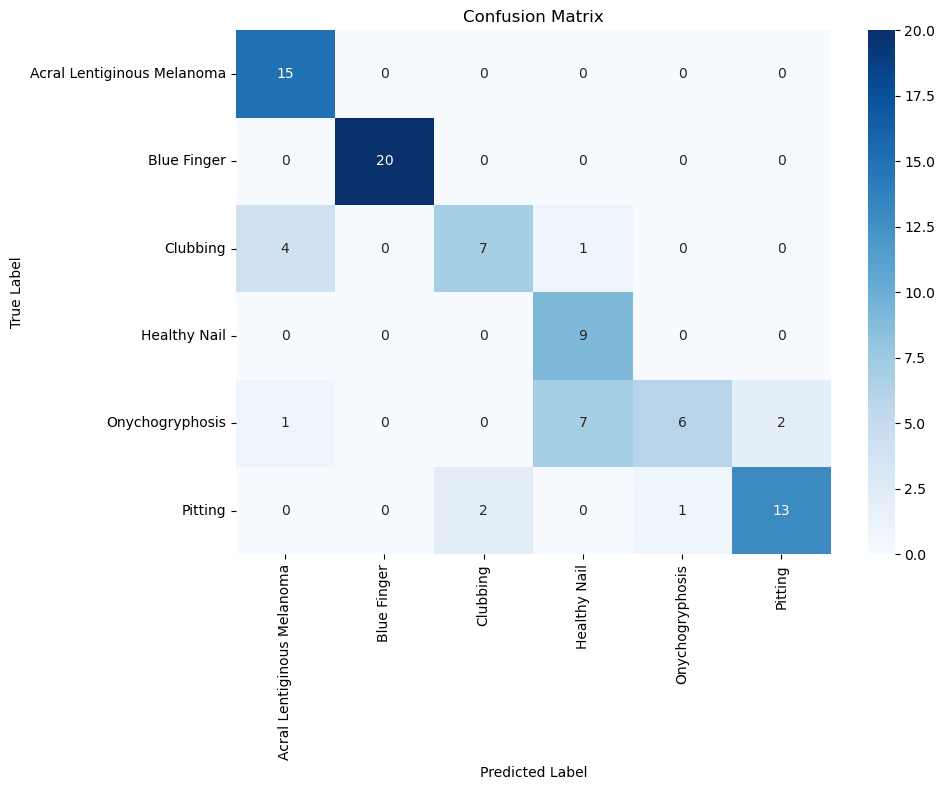

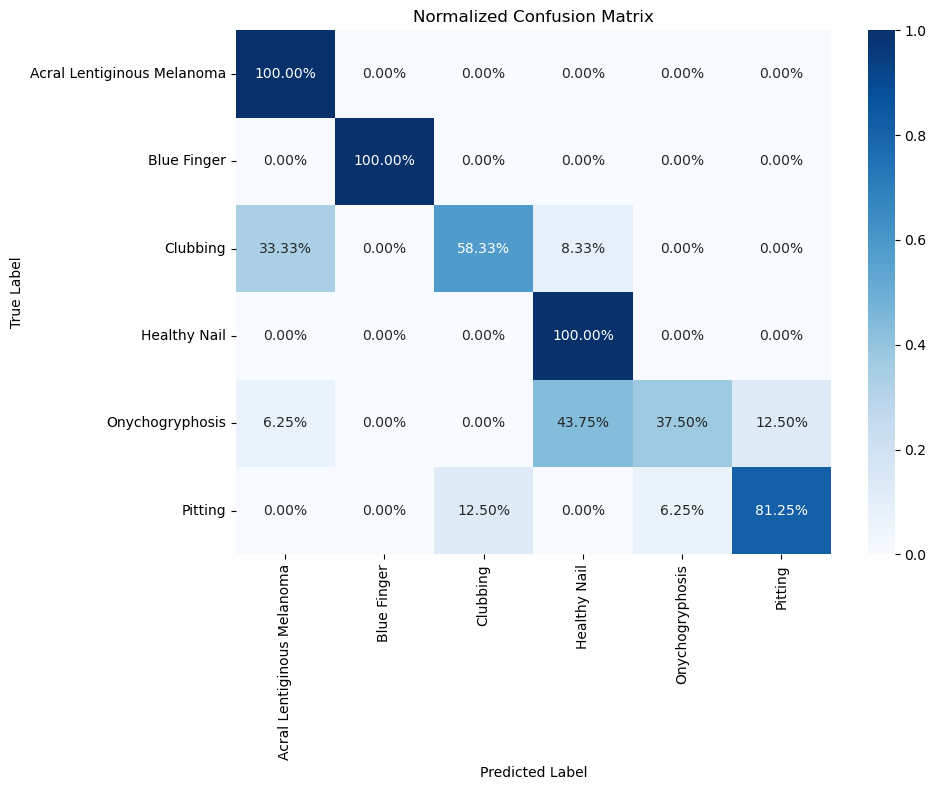

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix as conf_mat
import numpy as np

# Defining class labels
class_names = ['Acral Lentiginous Melanoma', 'Blue Finger', 'Clubbing', 'Healthy Nail', 'Onychogryphosis', 'Pitting']

cf = conf_mat(label_data, predictions)

# Plot raw confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
ncf = cf.astype('float') / cf.sum(axis=1, keepdims=True)  # Normalize by row (true labels)
sns.heatmap(ncf, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix as conf_mat

# Defining class lables
class_names = ['Acral Lentiginous Melanoma', 'Blue Finger', 'Clubbing', 'Healthy Nail', 'Onychogryphosis', 'Pitting']

cf = conf_mat(label_data, predictions)

# Calculate Overall Accuracy
overall_accuracy = np.trace(cf) / cf.sum()

# Calculate TP, FP, FN, TN for each class
metrics = []
for i, class_name in enumerate(class_names):
    TP = cf[i, i]
    FP = cf[:, i].sum() - TP
    FN = cf[i, :].sum() - TP
    TN = cf.sum() - TP - FP - FN
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    support = cf[i, :].sum()
    
    metrics.append({
        'Class': class_name,
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'TN': TN,
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-Score': round(f1, 4),
        'Support': support
    })

metrics_df = pd.DataFrame(metrics)

# Calculate Macro Average
macro_avg = {
    'Class': 'Macro Avg',
    'TP': ' ',
    'FP': ' ',
    'FN': ' ',
    'TN': ' ',
    'Precision': round(metrics_df['Precision'].mean(), 4),
    'Recall': round(metrics_df['Recall'].mean(), 4),
    'F1-Score': round(metrics_df['F1-Score'].mean(), 4),
    'Support': metrics_df['Support'].sum()
}

# Calculate Weighted Average
total_support = metrics_df['Support'].sum()
weighted_avg = {
    'Class': 'Weighted Avg',
    'TP': ' ',
    'FP': ' ',
    'FN': ' ',
    'TN': ' ',
    'Precision': round((metrics_df['Precision'] * metrics_df['Support']).sum() / total_support, 4),
    'Recall': round((metrics_df['Recall'] * metrics_df['Support']).sum() / total_support, 4),
    'F1-Score': round((metrics_df['F1-Score'] * metrics_df['Support']).sum() / total_support, 4),
    'Support': total_support
}

# Add averages to dataframe
metrics_df = pd.concat([metrics_df, pd.DataFrame([macro_avg, weighted_avg])], ignore_index=True)

# Print results
print(f"{'='*60}")
print(f"OVERALL ACCURACY: {round(overall_accuracy, 4)} ({round(overall_accuracy*100, 2)}%)")
print(f"{'='*60}\n")
print(metrics_df.to_string(index=False))

OVERALL ACCURACY: 0.7955 (79.55%)

                     Class TP FP FN TN  Precision  Recall  F1-Score  Support
Acral Lentiginous Melanoma 15  5  0 68     0.7500  1.0000    0.8571       15
               Blue Finger 20  0  0 68     1.0000  1.0000    1.0000       20
                  Clubbing  7  2  5 74     0.7778  0.5833    0.6667       12
              Healthy Nail  9  8  0 71     0.5294  1.0000    0.6923        9
           Onychogryphosis  6  1 10 71     0.8571  0.3750    0.5217       16
                   Pitting 13  2  3 70     0.8667  0.8125    0.8387       16
                 Macro Avg                 0.7968  0.7951    0.7628       88
              Weighted Avg                 0.8287  0.7954    0.7824       88
